In [3]:
#decision tree
import sys
import matplotlib
matplotlib.use('Agg')

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

%matplotlib inline

In [4]:
ignore_mos = [
    "IA", # Identification and authentication
    "mm", # main menu
    "MR", # SMS Account Summary
    "nl", # NLU menu How may I help you
    "ss", # Transfer
    "TA", # SMS Account Summary
    "TR", # Transfer
    "TS", # SMS Account Summary
  ]
df3 = pd.read_csv("file3.csv")
df4 = pd.read_csv("file4.csv")
df_raw = pd.concat([df3, df4])
df_raw

def clean_mos(mos):
  mos = mos + " "
  for ignore in ignore_mos:
    mos = mos.replace(ignore + " ", "")
  return mos.strip()

# Clean
df = df_raw.copy()
df["mos"] = df["mos"].apply(clean_mos)
df["resolved"] = df["resolved"].replace({"resolved": 1, "floor": 0})
df["timestamp"] = df["timestamp_call_key"].apply(lambda x: x.split(" ")[0])
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%y%m%d%H%M%S")
df["account_open_date"] = pd.to_datetime(df["account_open_date_18_march"])

drop_columns = ["timestamp_call_key",
                "account_open_date_13_march", "no_of_accounts_with_syf_18_march",
                "account_balance_18_march", "delinquency_history_18_march",
                "account_open_date_18_march", "account_status_18_march",
                "card_activation_status_18_march", "eservice_ind_18_march",
                "ebill_enrolled_status_18_march", "auto_pay_enrolled_status_18_march"]
df.drop(drop_columns, axis=1, inplace=True)

df.rename(columns={
    "no_of_accounts_with_syf_13_march": "no_of_accounts",
    "account_balance_13_march": "account_balance",
    "delinquency_history_13_march": "delinquency_history",
    "account_status_13_march": "account_status",
    "card_activation_status_13_march": "card_activation_status",
    "eservice_ind_13_march": "eservice_ind",
    "ebill_enrolled_status_13_march": "ebill_enrolled_status",
    "auto_pay_enrolled_status_13_march": "auto_pay_enrolled_status"
}, inplace=True)

def parse_delinquency_current(delinquency_history):
  return int(delinquency_history.strip("[]")[0])

def parse_delinquency_prior(delinquency_history):
  return int(delinquency_history.strip("[]")[1])

def ebill_change(value):
    if value == 'E':
        return 1
    elif value == 'B':
        return 2
    elif value == 'L':
        return 3
    else:
        return 0




# Feature engineering
df["account_age"] = df["timestamp"] - df["account_open_date"]
df["delinquency_current"] = df["delinquency_history"].apply(parse_delinquency_current)
df["delinquency_prior"] = df["delinquency_history"].apply(parse_delinquency_prior)
df["account_balance"] = df["account_balance"].fillna(0)
status_dummies = pd.get_dummies(df["account_status"], prefix="acc_status").astype(int)
df = pd.concat([df, status_dummies], axis=1)
df['ebill_enrolled_status'] = df['ebill_enrolled_status'].apply(ebill_change)
drop_columns = ["account_open_date", "delinquency_history", "account_status"]
df.drop(drop_columns, axis=1, inplace=True)


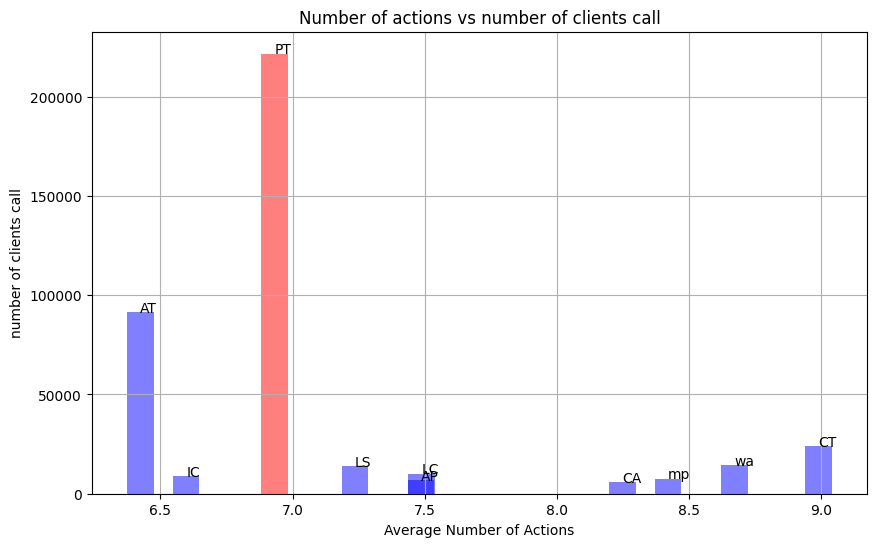

In [293]:
# for all the retailer s, clients fail the IA directly
df_raw[(df_raw.retailer_code == 'U')].groupby('reason').count()
#U: BA, 102
df_raw[(df_raw.retailer_code == 'U') & (df_raw.reason == 'BA')].mos.unique()
df_raw[(df_raw.reason == 'BA')].mos.unique()


# Assuming df_raw is your DataFrame and 'mos' is the column of interest.
# We first apply a function to split each entry by '\n', calculate lengths, and then find the mean.
df['num_of_action'] = df_raw['mos'].apply(lambda x: len(x.split(' ')))
temp = df.groupby('reason').agg({'num_of_action':'mean','card_activation_status':'count'}).sort_values('num_of_action',ascending=False)
# Now, if you want the overall average length across all rows:
# overall_average_length = df_raw['average_length'].mean()

# print(f"The overall average length is: {temp}")
# temp[temp.card_activation_status > 1000]
temp = temp[(temp.num_of_action > 6) & (temp.card_activation_status > 5000)]

bar_width = 1
colors = ['red' if idx == 'PT' else 'blue' for idx in temp.index]
plt.figure(figsize=(10, 6))  # Set the figure size as desired
plt.bar(temp['num_of_action'], temp['card_activation_status'], alpha=0.5,width = 0.1,color = colors)  # alpha is set for better visibility
for idx, row in temp.iterrows():
    plt.text(row['num_of_action'], row['card_activation_status'], str(idx), fontsize=10)

plt.title('Number of actions vs number of clients call')
plt.xlabel('Average Number of Actions')
plt.ylabel('number of clients call')
plt.grid(True)
plt.show()



In [5]:
status_columns = ['acc_status_A', 'acc_status_B', 'acc_status_C', 'acc_status_E', 'acc_status_F', 'acc_status_I', 'acc_status_L', 'acc_status_U', 'acc_status_Z']
df['combined_status'] = df[status_columns].max(axis=1)
df = df.drop(columns=status_columns)
df

,retailer_code,serial,reason,mos,resolved,no_of_accounts,account_balance,card_activation_status,eservice_ind,ebill_enrolled_status,auto_pay_enrolled_status,timestamp,account_age,delinquency_current,delinquency_prior,combined_status
0,D,10010009499,PP,PP,1,1.0,0.00,0,1,1,0,2024-03-15 17:32:50,3953 days 17:32:50,0,0,0
1,E,10006021998,BA,BA,0,2.0,143.28,0,1,1,0,2024-03-15 12:47:42,7480 days 12:47:42,0,0,0
2,J,10016007830,PT,AA BA PT,1,12.0,0.00,8,0,0,0,2024-03-17 11:42:37,2386 days 11:42:37,0,0,0
3,E,10008003199,BA,BA,1,2.0,44.98,0,0,3,0,2024-03-14 12:08:49,36 days 12:08:49,0,0,0
4,I,10013002037,BA,BA,0,6.0,7.00,0,1,0,0,2024-03-14 14:59:02,802 days 14:59:02,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894160,i,20012001463,BA,BA,1,14.0,1314.94,0,0,0,0,2024-03-14 12:01:18,765 days 12:01:18,0,0,0
894161,i,20012001463,BA,BA,1,14.0,1314.94,0,0,0,0,2024-03-14 12:03:36,765 days 12:03:36,0,0,0
894162,a,20001160188,PP,PP,1,7.0,35.66,0,0,0,0,2024-03-16 19:09:32,205 days 19:09:32,0,0,0
894163,d,20010020211,FD,,0,8.0,386.63,0,1,3,0,2024-03-17 21:33:41,1768 days 21:33:41,0,0,1


In [6]:
len(df[(df.retailer_code == 'C') & (df.resolved == 0)])/len(df[(df.retailer_code == 'C')])

0.17607392410647466

In [314]:
temp = df.groupby('reason').agg({'resolved':'mean','card_activation_status':'count'}).sort_values('resolved',ascending=True)
# how to show after the groupby? i dont wnat to add anything, just for one group, show all the other columns
temp[temp.resolved < 0.5].sort_values('card_activation_status',ascending=False)
floor = df[df.resolved == 0]

In [297]:
def count_recalls(df):
  df["recall"] = df.groupby("serial").cumcount()
  df["recall"] = df["recall"].fillna(0).astype(int)
count_recalls(df)

In [339]:
floor[floor.recall > 0].describe().delinquency_prior
# df[df.recall > 0].groupby(['reason']).agg({'card_activation_status':'count'}).sort_values('card_activation_status',ascending=False)
# hows the mos route is, reason changes of each client's recall

count    74436.00000
mean         0.12905
std          0.67653
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          8.00000
Name: delinquency_prior, dtype: float64

In [7]:
floor[floor.recall == 0].describe().delinquency_prior

NameError: name 'floor' is not defined

In [322]:
temp = df[df.reason == 'AT']
temp.groupby('serial').agg({'recall':'count'}).sort_values('recall',ascending=False).head(10)

,recall
serial,
20004002751,10
20004002615,10
20004002233,10
20004000844,10
10023000027,10
20004001285,9
20004004291,9
20004003744,9
20004005240,8


In [323]:
df_raw[df_raw.serial == 10023000027]

,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,account_balance_13_march,delinquency_history_13_march,account_open_date_13_march,account_status_13_march,card_activation_status_13_march,eservice_ind_13_march,ebill_enrolled_status_13_march,auto_pay_enrolled_status_13_march,no_of_accounts_with_syf_18_march,account_balance_18_march,delinquency_history_18_march,account_open_date_18_march,account_status_18_march,card_activation_status_18_march,eservice_ind_18_march,ebill_enrolled_status_18_march,auto_pay_enrolled_status_18_march
260237,240314015025 PHX7K2IX,D,10023000027,AT,IA BA MR nl AT,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260238,240314092243 DAL5BNPX,D,10023000027,AT,IA BA MR nl AT,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260239,240314101732 DAL3OMIM,D,10023000027,BA,IA BA,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260240,240314101858 DAL5TLUG,D,10023000027,AT,IA BA MR nl AT,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260241,240314125532 PHX3HDFE,D,10023000027,CT,IA BA MR nl AT nl CT mt RS TR,floor,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260242,240314162029 PHX3KJNH,D,10023000027,AT,IA BA MR nl AT,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260243,240314180025 PHX3YJW9,D,10023000027,AT,IA BA MR nl AT,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260244,240314184430 PHX6RD93,D,10023000027,BA,IA BA,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260245,240314224607 DAL18VQR,D,10023000027,BA,IA BA,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0
260246,240315003551 DAL6BBOV,D,10023000027,BA,IA BA,resolved,7.0,NaN,[00],8/12/2019,NaN,0,0,,0,7.0,NaN,[00],8/12/2019,NaN,0,0,,0


In [301]:

# Assuming 'df' is your DataFrame filtered where 'reason' == 'BA'
# and you've already performed the groupby operation and saved the result as 'grouped_df'

# Reshape the DataFrame so that each descriptive statistic is a column
reshaped_df = grouped_df.stack().reset_index()
# reshaped_df



# # Assuming your DataFrame is named df
# # First, filter out the rows for the mean
means_df = reshaped_df[reshaped_df['level_1'] == 'mean'].iloc[:, 2:].reset_index()
means_df
plt.figure(figsize=(20, 6))  

num_rows = means_df.shape[1]  # Number of rows equal to the number of variables
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(5, num_rows * 4))  # Adjust the figure size as needed

# If only one variable, ensure axes is iterable
if num_rows == 1:
    axes = [axes]

# Iterate over the rows of the subplot grid and the columns in your DataFrame
for ax, column in zip(axes, means_df.columns):
    sns.barplot(x=means_df.index, y=means_df[column], ax=ax)
    ax.set_title(f'Mean values for {column}')
    ax.set_ylabel('Mean')
    ax.set_xlabel('Categories')  # Or whatever the index represents

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



KeyError: 'level_1'

In [ ]:
reshaped_df

,resolved,level_1,serial,no_of_accounts,account_balance,eservice_ind,ebill_enrolled_status,auto_pay_enrolled_status,account_age,delinquency_current,delinquency_prior,acc_status_A,acc_status_B,acc_status_C,acc_status_E,acc_status_F,acc_status_I,acc_status_L,acc_status_U,acc_status_Z,num_of_action
0,0,count,1.583940e+05,156531.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000,158394.000000
1,0,mean,1.542172e+10,4.844082,1178.265620,0.415748,0.956192,0.048518,1846 days 21:25:10.533479808,0.060848,0.057654,0.002159,0.000000,0.016484,0.035046,0.008643,0.000000,0.002961,0.000688,0.000019,7.197716
2,0,std,4.982406e+09,3.697426,2200.567011,0.492852,1.047637,0.214859,2166 days 10:27:23.601618944,0.371834,0.370286,0.046417,0.000000,0.127329,0.183895,0.092565,0.000000,0.054334,0.026224,0.004352,1.774396
3,0,min,1.000100e+10,1.000000,-25596.000000,0.000000,0.000000,0.000000,3 days 00:43:53,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,0,25%,1.000305e+10,2.000000,0.000000,0.000000,0.000000,0.000000,344 days 16:19:38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
5,0,50%,2.000104e+10,4.000000,287.000000,0.000000,1.000000,0.000000,1084 days 23:03:22.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
6,0,75%,2.000303e+10,6.000000,1417.150000,1.000000,1.000000,0.000000,2643 days 12:07:48.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
7,0,max,2.005200e+10,121.000000,58641.710000,1.000000,3.000000,1.000000,24906 days 15:38:40,7.000000,7.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,11.000000
8,1,count,4.079570e+05,407421.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000,407957.000000
9,1,mean,1.424027e+10,5.014943,1160.099717,0.348980,0.910527,0.027356,1930 days 01:39:30.049414496,0.119015,0.085467,0.000811,0.000002,0.008253,0.020733,0.004172,0.000005,0.001429,0.000302,0.000005,3.390764


In [ ]:
grouped_df = df[df.reason == 'BA'].groupby('resolved').describe()
reshaped_df = grouped_df.stack().reset_index()
df

,retailer_code,serial,reason,mos,resolved,no_of_accounts,account_balance,card_activation_status,eservice_ind,ebill_enrolled_status,auto_pay_enrolled_status,timestamp,account_age,delinquency_current,delinquency_prior,acc_status_A,acc_status_B,acc_status_C,acc_status_E,acc_status_F,acc_status_I,acc_status_L,acc_status_U,acc_status_Z,num_of_action
0,D,10010009499,PP,PP,1,1.0,0.00,0,1,1,0,2024-03-15 17:32:50,3953 days 17:32:50,0,0,0,0,0,0,0,0,0,0,0,3
1,E,10006021998,BA,BA,0,2.0,143.28,0,1,1,0,2024-03-15 12:47:42,7480 days 12:47:42,0,0,0,0,0,0,0,0,0,0,0,5
2,J,10016007830,PT,AA BA PT,1,12.0,0.00,8,0,0,0,2024-03-17 11:42:37,2386 days 11:42:37,0,0,0,0,0,0,0,0,0,0,0,7
3,E,10008003199,BA,BA,1,2.0,44.98,0,0,3,0,2024-03-14 12:08:49,36 days 12:08:49,0,0,0,0,0,0,0,0,0,0,0,2
4,I,10013002037,BA,BA,0,6.0,7.00,0,1,0,0,2024-03-14 14:59:02,802 days 14:59:02,0,0,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894160,i,20012001463,BA,BA,1,14.0,1314.94,0,0,0,0,2024-03-14 12:01:18,765 days 12:01:18,0,0,0,0,0,0,0,0,0,0,0,4
894161,i,20012001463,BA,BA,1,14.0,1314.94,0,0,0,0,2024-03-14 12:03:36,765 days 12:03:36,0,0,0,0,0,0,0,0,0,0,0,2
894162,a,20001160188,PP,PP,1,7.0,35.66,0,0,0,0,2024-03-16 19:09:32,205 days 19:09:32,0,0,0,0,0,0,0,0,0,0,0,3
894163,d,20010020211,FD,,0,8.0,386.63,0,1,3,0,2024-03-17 21:33:41,1768 days 21:33:41,0,0,1,0,0,0,0,0,0,0,0,3


In [ ]:
# reduce recall rate

#identify recall
df_raw[df_raw.serial]
means_df = reshaped_df[reshaped_df['level_1'] == 'mean'].iloc[:, 2:].reset_index()
means_df

KeyboardInterrupt: 

In [342]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='resolved', y='account_age')
plt.title('Comparison of Mean Account Balances by Reason and Resolution Status')
plt.xlabel('Reason')
plt.ylabel('Mean Account Balance')
plt.xticks(rotation=90)  # Rotates the x labels to prevent overlap
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

KeyboardInterrupt: 